### Data Preprocessing 

In [1]:
!pip install --disable-pip-version-check -q tensorflow==2.8.1
!pip install --disable-pip-version-check -q transformers==4.46.0
!pip install protobuf==3.20.*
!pip install --disable-pip-version-check -q tensorflow==2.8.1

import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer
import sagemaker
import boto3

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.1
ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.1


2025-03-30 22:02:32.076571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
import boto3
import pandas as pd
from io import StringIO

# Define S3 bucket and key
s3_bucket = "team4bucket-mmm"
s3_key = "Patent_Data_Kaggle/Patent_Data.csv" 

# Initialize S3 client
s3 = boto3.client('s3')

# Load CSV file
response = s3.get_object(Bucket=s3_bucket, Key=s3_key)
data = response['Body'].read().decode('utf-8')

# Convert to Pandas DataFrame and filter out null/NaN products
patent_data = pd.read_csv(StringIO(data))

# Remove rows where the "product" column is null or NaN
patent_data = patent_data[patent_data["product"].notna()]

# Display the first few rows
print(patent_data.head())



      flag        case_no  filed_date  filing_year  status  \
49793   DC  9:15-cv-80001  2015-01-02         2015  Closed   
49794   DC  3:15-cv-00002  2015-01-02         2015  Closed   
49795   DC  2:15-cv-00003  2015-01-02         2015  Closed   
49796   DC  8:15-cv-00005  2015-01-02         2015  Closed   
49797   DC  4:15-cv-00005  2015-01-02         2015  Closed   

                                   court  \
49793    Florida Southern District Court   
49794      Texas Northern District Court   
49795          New Jersey District Court   
49796  California Central District Court   
49797    Missouri Eastern District Court   

                                               plaintiff  \
49793           Arrival Star Sa|Melvino Technologies Ltd   
49794                       Peschke Map Technologies LLC   
49795  Ground Management Holdings LLC|Orissa Holdings...   
49796                                     Prodeck 50 Inc   
49797                                Antennas Direct Inc   

 

/tmp/ipykernel_1170/551257500.py:17: DtypeWarning: Columns (13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_data = pd.read_csv(StringIO(data))


#### Clean entity type and cause of action columns 

In [3]:
patent_data['entity_type'].unique()

array(['NPE (Patent Assertion Entity)', 'NPE (Small Company)',
       'Operating Company', nan, 'NPE (Individual)', 'University',
       'Gov/NGO/Non-Profit', 'Gov'], dtype=object)

In [4]:
# Create the mapping dictionary
entity_mapping = {
    "Operating Company": "Operating Company",
    "NPE (Individual)": "NPE - Individual",
    "NPE (Patent Assertion Entity)": "NPE - PAE",
    "NPE (Small Company)": "NPE - Small Company",
    "University": "University",
    "Gov/NGO/Non-Profit": "Government/Non-Profit",
    "Gov": "Government"
}

# Apply the mapping and fill NaN with 'Unknown'
patent_data['entity_type'] = patent_data['entity_type'].map(entity_mapping).fillna('Unknown')

In [5]:
# Fill missing values 
patent_data = patent_data.assign(
    markman_hearing_date=patent_data['markman_hearing_date'].fillna("Not Provided"),
    product=patent_data['product'].fillna("Unknown"),
    judge=patent_data['judge'].fillna("Not Available"),
    industry=patent_data['industry'].fillna("Not Available"),
    sme_annotation=patent_data['sme_annotation'].fillna("Not Available")
)
patent_data['cause_of_action'] = patent_data['cause_of_action'].fillna('unknown')

In [6]:
# Ensure date columns are datetime
patent_data['filed_date'] = pd.to_datetime(patent_data['filed_date'], errors='coerce')
patent_data['closed_date'] = pd.to_datetime(patent_data['closed_date'], errors='coerce')

# Create case_duration in days
patent_data['case_duration'] = (patent_data['closed_date'] - patent_data['filed_date']).dt.days

# Replace missing or invalid durations with -1
patent_data['case_duration'] = patent_data['case_duration'].apply(lambda x: x if pd.notnull(x) and x >= 0 else -1)

In [7]:
patent_data['cause_of_action'].unique()

array(['Infringement', 'Declaratory Judgment', 'Patent Infringement',
       'unknown', 'Infringement|Declaratory Judgment', 'Others',
       'Declaratory Judgement',
       'Correction of Inventorship|Declaratory Judgment',
       'Correction of inventorship', 'False patent marking',
       'BPAI decision on appeal', 'Infringment', 'Breach of contract',
       'Infringement|False Patent Marking', 'Correction of Inventership',
       'Invalidity', 'copyright', 'Fraud based on misrepresentations',
       'Trademark', 'Patent NonInfringement  Declaratory Judgment',
       'Fed Question', 'b Civil Action to Protect Trade Secrets',
       'Patent Term Adjustment', 'Injunction', 'Federal Question',
       'dj Declaratory Judgment', 'pt Patent Infringement',
       'Trademark Infringement',
       'Recover profits from unlicensed use of design patent',
       'Rehabilitation of Labor', 'Copyright Infringement',
       'Patent NonInfringement Patent Applicant is Dissatisfied with PTO Decision

In [8]:
# Clean cause of action column

# make lowercase and strip whitespace 
patent_data['cause_of_action'] = patent_data['cause_of_action'].str.lower().str.strip()

# Replace Newlines \n and | with Commas
patent_data['cause_of_action'] = patent_data['cause_of_action'].str.replace(r'\n|\|', ',', regex=True)

# correct typos 
patent_data['cause_of_action'] = patent_data['cause_of_action'].replace({
    'infringment': 'infringement',
    'inventership': 'inventorship',
    'pt patent infringement': 'patent infringement',
    'nr notice of removal': 'notice of removal',
    'ej fed question enforcement of judgment': 'fed question enforcement of judgment',
    'dj declaratory judgment': 'declaratory judgment',
    'motquash': 'motion to quash',
    'la trademark infringement lanham act': 'trademark infringement lanham act'
})

# create new column 'primary_cause' and extract the first entry from cause of action column
patent_data['primary_cause'] = patent_data['cause_of_action'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

# Create a set of standardized categories
categories = {
    'patent': 'patent',
    'patent infringement': 'patent infringement',
    'trademark': 'trademark',
    'trademark infringement': 'trademark infringement',
    'copyright': 'copyright',
    'antitrust': 'antitrust',
    'trade secret': 'trade secret',
    'breach of contract': 'breach of contract',
    'declaratory judgment': 'declaratory judgment',
    'infringement': 'infringement',
    'false patent marking': 'false patent marking',
    'correction of inventorship': 'correction of inventorship',
    'patent interference': 'patent interference',
    'unfair competition lanham act': 'lanham act',
}

def map_category(cause):
    if pd.isnull(cause):
        return 'unknown'
    for key in categories.keys():
        if key in cause:
            return categories[key]
    return 'other'

patent_data['standard_cause'] = patent_data['cause_of_action'].apply(map_category)

Note: Here a new column 'standard_cause' was created that holds the standardized categories of the 'cause_of_action' column. A reduced set list good for analyzing.

In [9]:
patent_data['standard_cause'].unique()

array(['infringement', 'declaratory judgment', 'patent', 'other',
       'correction of inventorship', 'breach of contract', 'copyright',
       'trademark', 'trade secret', 'antitrust'], dtype=object)

In [10]:
#clean_data_patent = patent_data.dropna()
clean_data_patent = patent_data

In [11]:
# Display DataFrame
patent_data.head()

flag        case_no filed_date  filing_year  status  \
49793   DC  9:15-cv-80001 2015-01-02         2015  Closed   
49794   DC  3:15-cv-00002 2015-01-02         2015  Closed   
49795   DC  2:15-cv-00003 2015-01-02         2015  Closed   
49796   DC  8:15-cv-00005 2015-01-02         2015  Closed   
49797   DC  4:15-cv-00005 2015-01-02         2015  Closed   

                                   court  \
49793    Florida Southern District Court   
49794      Texas Northern District Court   
49795          New Jersey District Court   
49796  California Central District Court   
49797    Missouri Eastern District Court   

                                               plaintiff  \
49793           Arrival Star Sa|Melvino Technologies Ltd   
49794                       Peschke Map Technologies LLC   
49795  Ground Management Holdings LLC|Orissa Holdings...   
49796                                     Prodeck 50 Inc   
49797                                Antennas Direct Inc   

                                 parent_company 3rd_funded  \
49793  Arrival Star SA|Melvino Technologies Ltd        NaN   
49794              Peschke Map Technologies LLC        NaN   
49795                                       NaN        NaN   
49796                            Prodeck 50 Inc        NaN   
49797                                       NaN        NaN   

                                   defendant  ...          entity_type  \
49793               Pizza Hut Of America LLC  ...            NPE - PAE   
49794                  Northpark Partners Lp  ...  NPE - Small Company   
49795  Deem Inc|Global Ground Automation Inc  ...    Operating Company   
49796   International Technical Coatings Inc  ...    Operating Company   
49797                    1byone Products Inc  ...              Unknown   

      sme_annotation       industry             judge closed_date  \
49793    Large Op Co              T     Not Available  2015-06-02   
49794            SME              T     Not Available  2015-07-07   
49795  Not Available              T     Not Available  2015-05-20   
49796  Not Available              O  Cormac J. Carney  2015-02-12   
49797  Not Available  Not Available     Not Available  2015-04-27   

      markman_hearing_date                                            product  \
49793         Not Provided  â€œADVANCE SHIP NOTICEâ€ and â€œSHIPMENT CONF...   
49794         Not Provided  Store layout mapping products and services (ht...   
49795         Not Provided  Data communication systems (Transportation ser...   
49796         Not Provided            â€œPerformance Panelâ€ - rack/shelving   
49797         Not Provided                                  Disco party light   

      case_duration         primary_cause        standard_cause  
49793         151.0          infringement          infringement  
49794         186.0          infringement          infringement  
49795         138.0  declaratory judgment  declaratory judgment  
49796          41.0   patent infringement                patent  
49797         115.0          infringement          infringement  

[5 rows x 22 columns]

#### Add number patent

In [12]:
# Remove rows where patents are null
patent_data = patent_data.dropna(subset=['patents'])

# Or if you want to be more explicit about different null values
patent_data = patent_data[patent_data['patents'].notna() & (patent_data['patents'] != '')]

# Then apply the patent counting function
def count_patents(patents):
    # If patents is NaN or empty, return 0
    if pd.isna(patents) or patents == '':
        return 0
    
    # Convert to string to handle different input types
    patents_str = str(patents)
    
    # Count the number of '|' and add 1 to get the patent count
    # For "|5682318|6010156", this will return 2
    return patents_str.count('|') + 1

# Apply the function
patent_data['number_patent'] = patent_data['patents'].apply(count_patents)
patent_data['patent'] = patent_data['patents']# Convert number_patent to string
patent_data['number_patent'] = patent_data['number_patent'].astype(str)
patent_data = patent_data.rename(columns={'case_no': 'case_id'})
patent_data['case_id'] = patent_data['case_id'].astype(str)

patent_data.head()

flag        case_id filed_date  filing_year  status  \
49793   DC  9:15-cv-80001 2015-01-02         2015  Closed   
49794   DC  3:15-cv-00002 2015-01-02         2015  Closed   
49795   DC  2:15-cv-00003 2015-01-02         2015  Closed   
49796   DC  8:15-cv-00005 2015-01-02         2015  Closed   
49797   DC  4:15-cv-00005 2015-01-02         2015  Closed   

                                   court  \
49793    Florida Southern District Court   
49794      Texas Northern District Court   
49795          New Jersey District Court   
49796  California Central District Court   
49797    Missouri Eastern District Court   

                                               plaintiff  \
49793           Arrival Star Sa|Melvino Technologies Ltd   
49794                       Peschke Map Technologies LLC   
49795  Ground Management Holdings LLC|Orissa Holdings...   
49796                                     Prodeck 50 Inc   
49797                                Antennas Direct Inc   

                                 parent_company 3rd_funded  \
49793  Arrival Star SA|Melvino Technologies Ltd        NaN   
49794              Peschke Map Technologies LLC        NaN   
49795                                       NaN        NaN   
49796                            Prodeck 50 Inc        NaN   
49797                                       NaN        NaN   

                                   defendant  ...       industry  \
49793               Pizza Hut Of America LLC  ...              T   
49794                  Northpark Partners Lp  ...              T   
49795  Deem Inc|Global Ground Automation Inc  ...              T   
49796   International Technical Coatings Inc  ...              O   
49797                    1byone Products Inc  ...  Not Available   

                  judge closed_date markman_hearing_date  \
49793     Not Available  2015-06-02         Not Provided   
49794     Not Available  2015-07-07         Not Provided   
49795     Not Available  2015-05-20         Not Provided   
49796  Cormac J. Carney  2015-02-12         Not Provided   
49797     Not Available  2015-04-27         Not Provided   

                                                 product case_duration  \
49793  â€œADVANCE SHIP NOTICEâ€ and â€œSHIPMENT CONF...         151.0   
49794  Store layout mapping products and services (ht...         186.0   
49795  Data communication systems (Transportation ser...         138.0   
49796            â€œPerformance Panelâ€ - rack/shelving          41.0   
49797                                  Disco party light         115.0   

              primary_cause        standard_cause number_patent  \
49793          infringement          infringement             3   
49794          infringement          infringement             1   
49795  declaratory judgment  declaratory judgment             1   
49796   patent infringement                patent             1   
49797          infringement          infringement             1   

                        patent  
49793  7400970|6952645|6904359  
49794                  6397143  
49795                  5953706  
49796                  8919585  
49797                  7839347  

[5 rows x 24 columns]

In [13]:
#!pip install matplotlib

In [14]:
# Define the categorization function
def categorize_duration(duration):
    if duration < 80:
        return "Low"
    elif 80 <= duration < 320:
        return "Medium"
    
    else:
        return "High"

# Apply the categorization function
df=patent_data
df["duration_type"] = df["case_duration"].apply(categorize_duration)
print(df["duration_type"].value_counts())

duration_type
Medium    12473
Low        9477
High       6104
Name: count, dtype: int64


duration_type
Medium    12473
Low        9477
High       6104
Name: count, dtype: int64


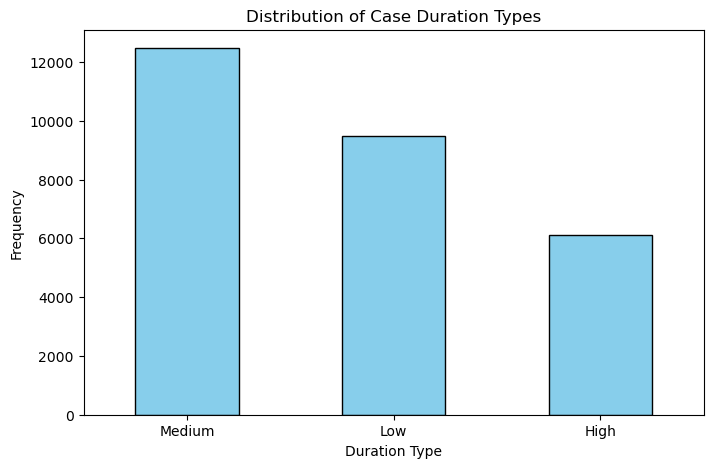

In [15]:
# Check the full distribution
import matplotlib.pyplot as plt


# Apply the categorization function
df["duration_type"] = df["case_duration"].apply(categorize_duration)
print(df["duration_type"].value_counts())

# Plot the distribution of categorized durations
plt.figure(figsize=(8, 5))
df["duration_type"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Case Duration Types")
plt.xlabel("Duration Type")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

In [16]:
# Count occurrences of each category in 'standard_cause'
standard_cause_counts = df['standard_cause'].value_counts()

# Print the counts
print(standard_cause_counts)

standard_cause
infringement                  23036
patent                         3388
declaratory judgment            966
other                           639
correction of inventorship       11
breach of contract                7
trademark                         3
copyright                         2
trade secret                      1
antitrust                         1
Name: count, dtype: int64


### BERT 

In [17]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

In [18]:
# set up tokenizer 
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") #This loads the pre-trained tokenizer for DistilBERT

# Label set up
LABEL_COLUMN = "standard_cause"
LABEL_VALUES = [
    'patent',
    'infringement',
    'other',
    'declaratory judgment',
    'breach of contract',
    'correction of inventorship',
    'trademark',
    'lanham act',
    'trade secret',
    'copyright',
    'antitrust'
]

# label map
label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i

# Input Features Class
class InputFeatures(object):
    """BERT feature vectors."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, case_id, date, label):
        self.input_ids = input_ids        # Token IDs from tokenizer
        self.input_mask = input_mask      # Attention mask (1 for real tokens, 0 for padding)
        self.segment_ids = segment_ids    # Token type IDs 
        self.label_id = label_id          # Encoded integer label
        self.case_id = case_id        # unique ID for the case 
        self.date = date                  # date feature
        self.label = label                # original text label

# Input class 
class Input(object):
    def __init__(self, text, case_id, date, label=None, court=None, industry=None, 
                 case_duration=None, duration_type=None, number_patent=None):
        self.text = text
        self.case_id = case_id
        self.date = date
        self.label = label
        self.court = court
        self.industry = industry
        self.case_duration = case_duration
        self.duration_type = duration_type
        self.number_patent = number_patent
        

# Converting Input to Features
def convert_input(the_input, max_seq_length):
    tokens = tokenizer.tokenize(the_input.text)
    tokens.insert(0, '[CLS]')
    tokens.append('[SEP]')
    print("**{} tokens**\n{}\n".format(len(tokens), tokens))

    encode_plus_tokens = tokenizer.encode_plus(
        the_input.text,
        padding='max_length',
        max_length=max_seq_length,
        truncation=True
    )

    input_ids = encode_plus_tokens["input_ids"]
    input_mask = encode_plus_tokens["attention_mask"]
    segment_ids = [0] * max_seq_length

    label_id = label_map[the_input.label]

    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        case_id=the_input.case_id,
        date=the_input.date,
        label=the_input.label,
    )

    return features

# Transforming Data to TFRecord
def transform_inputs_to_tfrecord(inputs, output_file, max_seq_length):
    records = []
    tf_record_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, the_input) in enumerate(inputs):
        features = convert_input(the_input, max_seq_length)

        all_features = collections.OrderedDict()

        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())

        records.append(
            {
                "input_ids": features.input_ids,
                "input_mask": features.input_mask,
                "segment_ids": features.segment_ids,
                "label_id": features.label_id,
                "case_id": the_input.case_id,
                "date": the_input.date,
                "label": features.label,
                "court": the_input.court,
                "industry": the_input.industry,
                "case_duration": the_input.case_duration,
                "duration_type": the_input.duration_type,
                "number_patent": the_input.number_patent, 
            }
        )

    tf_record_writer.close()

    return records


In [19]:
print(df["duration_type"].value_counts())

duration_type
Medium    12473
Low        9477
High       6104
Name: count, dtype: int64


### Feature Store requires an Event Time feature

In [20]:
from datetime import datetime
from time import strftime

# timestamp = datetime.now().replace(microsecond=0).isoformat()
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(timestamp)


2025-03-30T22:02:40Z


#### Run BERT on Data

In [21]:
df = df.dropna(subset=['patents'])

In [22]:
import pandas as pd


# Or if you want to be more explicit about different null values
df = df[df['patents'].notna() & (df['patents'] != '')]

# Then apply the patent counting function
def count_patents(patents):
    # If patents is NaN or empty, return 0
    if pd.isna(patents) or patents == '':
        return 0
    
    # Convert to string to handle different input types
    patents_str = str(patents)
    
    # Count the number of '|' and add 1 to get the patent count
    # For "|5682318|6010156", this will return 2
    return patents_str.count('|') + 1

# Apply the function
df['number_patent'] = df['patents'].apply(count_patents)
# Original data


# Create DataFrame
df = pd.DataFrame(df, columns=["standard_cause", "number_patent", "cause_of_action", "case_id", "filed_date", "court", "industry","duration_type","case_duration"])


# Generate full_text column dynamically
df["full_text"] = df["cause_of_action"] + " | " + df["court"] + " | " + df["industry"] + " | Number of Patents: " + df['number_patent'].astype(str)


# Define column names
LABEL_COLUMN = "standard_cause"
TEXT_COLUMN = "full_text"
CASE_ID_COLUMN = "case_id"
DATE_COLUMN = "filed_date"

# Use the Input class to create BERT input examples
inputs = df.apply(
    lambda x: Input(
        label=x[LABEL_COLUMN],
        text=x[TEXT_COLUMN],
        case_id=x[CASE_ID_COLUMN],        
        date=x[DATE_COLUMN],
        court=x["court"],
        industry=x["industry"],
        case_duration=x["case_duration"],
        duration_type=x["duration_type"],
        number_patent=x["number_patent"],
    ),
    axis=1
).tolist()

# Check output
print(df.head())

             standard_cause  number_patent       cause_of_action  \
49793          infringement              3          infringement   
49794          infringement              1          infringement   
49795  declaratory judgment              1  declaratory judgment   
49796                patent              1   patent infringement   
49797          infringement              1          infringement   

             case_id filed_date                              court  \
49793  9:15-cv-80001 2015-01-02    Florida Southern District Court   
49794  3:15-cv-00002 2015-01-02      Texas Northern District Court   
49795  2:15-cv-00003 2015-01-02          New Jersey District Court   
49796  8:15-cv-00005 2015-01-02  California Central District Court   
49797  4:15-cv-00005 2015-01-02    Missouri Eastern District Court   

            industry duration_type  case_duration  \
49793              T        Medium          151.0   
49794              T        Medium          186.0   
49795      

In [23]:
print(df["duration_type"].value_counts())

duration_type
Medium    12473
Low        9477
High       6104
Name: count, dtype: int64


#### Save TFRecords

In [24]:
import os

# Define the output directory and file path
output_dir = "./df-tfrecord-featurestore"
output_file = os.path.join(output_dir, "df.tfrecord")

# Get the absolute path of the file
absolute_path = os.path.abspath(output_file)

# Print out the details
print("Output Directory:", os.path.abspath(output_dir))
print("Output File Name:", "df.tfrecord")
print("Full Absolute Path:", absolute_path)
print("Does the directory exist?", os.path.exists(output_dir))
print("Current Working Directory:", os.getcwd())

Output Directory: /home/sagemaker-user/ADS508-Team4/df-tfrecord-featurestore
Output File Name: df.tfrecord
Full Absolute Path: /home/sagemaker-user/ADS508-Team4/df-tfrecord-featurestore/df.tfrecord
Does the directory exist? True
Current Working Directory: /home/sagemaker-user/ADS508-Team4


In [25]:
output_file = "./df-tfrecord-featurestore/df.tfrecord"

#### Add Features to SageMaker Feature Store

In [26]:
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

#### Create a feature group

In [27]:
from time import gmtime, strftime, sleep

feature_group_name = "data-feature-group-" + strftime("%d-%H-%M-%S", gmtime())
print(feature_group_name)

data-feature-group-30-22-02-41


In [28]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="case_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="court", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="industry", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="case_duration", feature_type=FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition(feature_name="duration_type", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="number_patent", feature_type=FeatureTypeEnum.INTEGRAL),
]


In [29]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)
print(feature_group)

FeatureGroup(name='data-feature-group-30-22-02-41', sagemaker_session=<sagemaker.session.Session object at 0x7f808ef07a50>, feature_definitions=[FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='segment_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None), FeatureDefinition(feature_name='case_id', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None), FeatureDefinition(feature_name='label', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None), FeatureDefinition(feature_name='split_type',

#### Set S3 Prefix for Offline Feature Store

In [30]:
# Specify record identifier and event time features
record_identifier_feature_name = "case_id"
event_time_feature_name = "date"

#Set S3 Prefix for Offline Feature Store
prefix = "data-feature-store-" + timestamp
print(prefix)

data-feature-store-2025-03-30T22:02:40Z


In [31]:
# create the feature group 
feature_group.create(
    s3_uri=f"s3://{bucket}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=False,
)


{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:500441705565:feature-group/data-feature-group-30-22-02-41',
 'ResponseMetadata': {'RequestId': 'd5b307f8-0b98-4b74-9468-a4a719352d0d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd5b307f8-0b98-4b74-9468-a4a719352d0d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Sun, 30 Mar 2025 22:02:41 GMT'},
  'RetryAttempts': 0}}

#### Review the Records to Ingest into Feature Store

In [32]:
import os

output_dir = "./df-tfrecord-featurestore/"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "df.tfrecord")


In [33]:
max_seq_length = 64
records = transform_inputs_to_tfrecord(inputs, output_file, max_seq_length)

**16 tokens**
['[CLS]', 'infringement', '|', 'florida', 'southern', 'district', 'court', '|', 't', '|', 'number', 'of', 'patents', ':', '3', '[SEP]']

**16 tokens**
['[CLS]', 'infringement', '|', 'texas', 'northern', 'district', 'court', '|', 't', '|', 'number', 'of', 'patents', ':', '1', '[SEP]']

**19 tokens**
['[CLS]', 'dec', '##lar', '##atory', 'judgment', '|', 'new', 'jersey', 'district', 'court', '|', 't', '|', 'number', 'of', 'patents', ':', '1', '[SEP]']

**17 tokens**
['[CLS]', 'patent', 'infringement', '|', 'california', 'central', 'district', 'court', '|', 'o', '|', 'number', 'of', 'patents', ':', '1', '[SEP]']

**17 tokens**
['[CLS]', 'infringement', '|', 'missouri', 'eastern', 'district', 'court', '|', 'not', 'available', '|', 'number', 'of', 'patents', ':', '1', '[SEP]']

**16 tokens**
['[CLS]', 'infringement', '|', 'texas', 'eastern', 'district', 'court', '|', 't', '|', 'number', 'of', 'patents', ':', '2', '[SEP]']

**16 tokens**
['[CLS]', 'infringement', '|', 'texas', '

#### Ingest Records into Feature Store

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert records to DataFrame
df_records = pd.DataFrame.from_dict(records)

# Split data: 80% train, 20% temp (validation + test)
train_df, temp_df = train_test_split(df_records, test_size=0.20, random_state=42)

# Split temp data into 15% validation and 5% test
validation_df, test_df = train_test_split(temp_df, test_size=0.25, random_state=42)  # 0.25 * 20% = 5%

# Add the split type column
train_df["split_type"] = "train"
validation_df["split_type"] = "validation"
test_df["split_type"] = "test"

# Combine the splits into one DataFrame
df_records = pd.concat([train_df, validation_df, test_df], axis=0)

# Check the distribution
print(df_records["split_type"].value_counts())

# Print the head of the final DataFrame
print(df_records.head())


split_type
train         22443
validation     4208
test           1403
Name: count, dtype: int64
                                               input_ids  \
15409  [101, 20701, 1064, 7756, 2212, 2457, 1064, 105...   
12042  [101, 20701, 1064, 8452, 2212, 2457, 1064, 105...   
20629  [101, 20701, 1064, 3516, 2670, 2212, 2457, 106...   
12304  [101, 20701, 1064, 3448, 2789, 2212, 2457, 106...   
8879   [101, 20701, 1064, 3516, 2670, 2212, 2457, 106...   

                                              input_mask  \
15409  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12042  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
20629  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12304  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8879   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                             segment_ids  label_id  \
15409  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1   
12042  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### Cast DataFrame Object to Supported Feature Store Data Type String

In [35]:
print(df_records.dtypes)

input_ids                object
input_mask               object
segment_ids              object
label_id                  int64
case_id                  object
date             datetime64[ns]
label                    object
court                    object
industry                 object
case_duration           float64
duration_type            object
number_patent             int64
split_type               object
dtype: object


In [36]:
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

In [37]:
cast_object_to_string(df_records)

In [38]:
print(df_records.dtypes)

input_ids        string[python]
input_mask       string[python]
segment_ids      string[python]
label_id                  int64
case_id          string[python]
date             datetime64[ns]
label            string[python]
court            string[python]
industry         string[python]
case_duration           float64
duration_type    string[python]
number_patent             int64
split_type       string[python]
dtype: object


In [39]:
df_records.head()

input_ids  \
15409  [101, 20701, 1064, 7756, 2212, 2457, 1064, 105...   
12042  [101, 20701, 1064, 8452, 2212, 2457, 1064, 105...   
20629  [101, 20701, 1064, 3516, 2670, 2212, 2457, 106...   
12304  [101, 20701, 1064, 3448, 2789, 2212, 2457, 106...   
8879   [101, 20701, 1064, 3516, 2670, 2212, 2457, 106...   

                                              input_mask  \
15409  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12042  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
20629  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12304  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8879   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                             segment_ids  label_id  \
15409  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1   
12042  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1   
20629  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1   
12304  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1   
8879   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1   

             case_id       date         label  \
15409  2:18-cv-01076 2018-06-15  infringement   
12042  1:17-cv-00941 2017-07-13  infringement   
20629  0:19-cv-63139 2019-12-23  infringement   
12304  2:17-cv-00412 2017-08-03  infringement   
8879   9:16-cv-81676 2016-09-30  infringement   

                                 court industry  case_duration duration_type  \
15409            Nevada District Court        T          152.0        Medium   
12042          Delaware District Court        T          197.0        Medium   
20629  Florida Southern District Court        T           74.0           Low   
12304  Virginia Eastern District Court        T          447.0          High   
8879   Florida Southern District Court        T          433.0          High   

       number_patent split_type  
15409              4      train  
12042              1      train  
20629              1      train  
12304              2      train  
8879               3      train

In [40]:
df_records_short=df_records.head()

In [41]:
df_records_short = df_records_short.dropna()

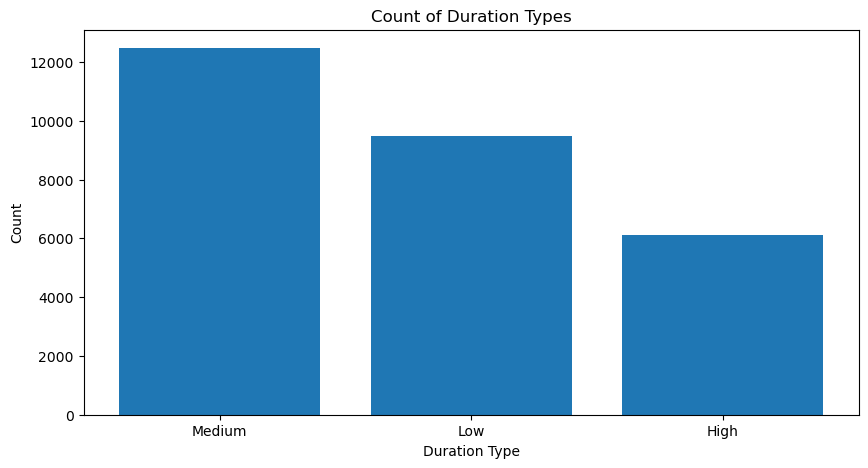

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df_records is your DataFrame 
duration_type_counts = df_records['duration_type'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(duration_type_counts.index, duration_type_counts.values)
plt.xlabel('Duration Type')
plt.ylabel('Count')
plt.title('Count of Duration Types')

plt.show()

### FUSION MODEL Final Data Preparation

#### Step 1: Load Pre-trained BERT Model

In [43]:
import tensorflow as tf
import numpy as np
from transformers import TFDistilBertModel, DistilBertConfig

# Load pre-trained DistilBERT model (same as you used for tokenization)
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased", config=config)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


#### Step 2: Generate BERT Embeddings from Inputs

In [54]:
# Function to convert DataFrame records to numpy arrays
def prepare_bert_input(record):
    # Convert string representation of lists to actual lists of integers if needed
    input_ids = eval(record['input_ids']) if isinstance(record['input_ids'], str) else record['input_ids']
    input_mask = eval(record['input_mask']) if isinstance(record['input_mask'], str) else record['input_mask']
    segment_ids = eval(record['segment_ids']) if isinstance(record['segment_ids'], str) else record['segment_ids']
    
    # Ensure arrays have consistent length (max_seq_length)
    input_ids = input_ids[:max_seq_length] + [0] * (max_seq_length - len(input_ids))
    input_mask = input_mask[:max_seq_length] + [0] * (max_seq_length - len(input_mask))
    segment_ids = segment_ids[:max_seq_length] + [0] * (max_seq_length - len(segment_ids))
    
    return np.array(input_ids), np.array(input_mask), np.array(segment_ids)

# Generate embeddings for each record
def generate_bert_embeddings(df, bert_model, batch_size=32):
    all_embeddings = []
    
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        
        # Prepare batch inputs
        batch_input_ids = []
        batch_attention_mask = []
        batch_token_type_ids = []
        
        for _, record in batch.iterrows():
            input_ids, attention_mask, token_type_ids = prepare_bert_input(record)
            batch_input_ids.append(input_ids)
            batch_attention_mask.append(attention_mask)
            batch_token_type_ids.append(token_type_ids)
        
        # Convert to tensors
        input_ids_tensor = tf.convert_to_tensor(batch_input_ids, dtype=tf.int32)
        attention_mask_tensor = tf.convert_to_tensor(batch_attention_mask, dtype=tf.int32)
        token_type_ids_tensor = tf.convert_to_tensor(batch_token_type_ids, dtype=tf.int32)
        
        # Get BERT embeddings (using [CLS] token)
        outputs = bert_model(
            input_ids=input_ids_tensor,
            attention_mask=attention_mask_tensor
        )
        
        # Get [CLS] token embeddings (first token)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        all_embeddings.extend(cls_embeddings)
        
        print(f"Processed batch {i//batch_size + 1}/{(len(df) + batch_size - 1)//batch_size}")
    
    return np.array(all_embeddings)

# Create embeddings
embeddings = generate_bert_embeddings(df_records, bert_model, batch_size=128)

Processed batch 1/220
Processed batch 2/220
Processed batch 3/220
Processed batch 4/220
Processed batch 5/220
Processed batch 6/220
Processed batch 7/220
Processed batch 8/220
Processed batch 9/220
Processed batch 10/220
Processed batch 11/220
Processed batch 12/220
Processed batch 13/220
Processed batch 14/220
Processed batch 15/220
Processed batch 16/220
Processed batch 17/220
Processed batch 18/220
Processed batch 19/220
Processed batch 20/220
Processed batch 21/220
Processed batch 22/220
Processed batch 23/220
Processed batch 24/220
Processed batch 25/220
Processed batch 26/220
Processed batch 27/220
Processed batch 28/220
Processed batch 29/220
Processed batch 30/220
Processed batch 31/220
Processed batch 32/220
Processed batch 33/220
Processed batch 34/220
Processed batch 35/220
Processed batch 36/220
Processed batch 37/220
Processed batch 38/220
Processed batch 39/220
Processed batch 40/220
Processed batch 41/220
Processed batch 42/220
Processed batch 43/220
Processed batch 44/2

#### Show results

In [55]:
# Display the shape of the embeddings array
print("Embeddings shape:", embeddings.shape)

# Show the first embedding vector (first 10 values)
print("\nFirst embedding vector (first 10 values):")
print(embeddings[0][:10])

# Display a sample of embeddings
print("\nSample of first 3 embeddings (first 5 values each):")
for i in range(3):
    print(f"Record {i+1}:", embeddings[i][:5])

Embeddings shape: (28054, 768)

First embedding vector (first 10 values):
[-0.1453701   0.11668711 -0.1141483  -0.03090311  0.09525569 -0.07717377
  0.25035     0.08990175 -0.22355781 -0.05871907]

Sample of first 3 embeddings (first 5 values each):
Record 1: [-0.1453701   0.11668711 -0.1141483  -0.03090311  0.09525569]
Record 2: [-0.18526083  0.1059764  -0.17786    -0.04610341  0.1517657 ]
Record 3: [-0.15435605  0.1190103  -0.10986719 -0.01985693  0.15795168]


#### Step 3: Prepare Metadata Features

In [56]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create encoders for categorical features
court_encoder = OneHotEncoder(sparse_output=False)
industry_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform categorical features
court_encoded = court_encoder.fit_transform(df_records[['court']])
industry_encoded = industry_encoder.fit_transform(df_records[['industry']])

# Normalize numerical features
scaler = StandardScaler()
number_patent_scaled = scaler.fit_transform(df_records[['number_patent']])

#### Step 4: Combine BERT Embeddings with Metadata (Fusion)

In [57]:
# Combine all features for the fusion model
X_combined = np.hstack([
    embeddings,                 # BERT embeddings
    court_encoded,              # One-hot encoded courts
    industry_encoded,           # One-hot encoded industries
    number_patent_scaled        # Scaled number of patents
])

# Prepare the target variable (duration_type)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_records['duration_type'])  # Convert 'low', 'medium', 'high' to 0, 1, 2

# Split data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

In [58]:
# Print the shape of the combined features
print("Shape of combined features (X_combined):", X_combined.shape)

# Print the first few rows
print("\nFirst few rows of combined features:")
print(X_combined[:5])

# Get more detailed information about the features
print("\nFeature composition:")
print(f"BERT Embeddings: {embeddings.shape}")
print(f"Court Encoded: {court_encoded.shape}")
print(f"Industry Encoded: {industry_encoded.shape}")
print(f"Number Patent Scaled: {number_patent_scaled.shape}")

# If you want to understand the total features
total_features = (
    embeddings.shape[1] + 
    court_encoded.shape[1] + 
    industry_encoded.shape[1] + 
    number_patent_scaled.shape[1]
)
print(f"\nTotal number of features: {total_features}")

# Print the unique classes in the target variable
print("\nUnique classes in duration_type:")
print(label_encoder.classes_)
print("Encoded classes:", np.unique(y))

Shape of combined features (X_combined): (28054, 872)

First few rows of combined features:
[[-0.1453701   0.11668711 -0.1141483  ...  0.          1.
   0.59117609]
 [-0.18526083  0.1059764  -0.17786001 ...  0.          1.
  -0.54565529]
 [-0.15435605  0.1190103  -0.10986719 ...  0.          1.
  -0.54565529]
 [-0.19221804  0.11856496 -0.12156835 ...  0.          1.
  -0.1667115 ]
 [-0.16014072  0.11482489 -0.09449051 ...  0.          1.
   0.2122323 ]]

Feature composition:
BERT Embeddings: (28054, 768)
Court Encoded: (28054, 99)
Industry Encoded: (28054, 4)
Number Patent Scaled: (28054, 1)

Total number of features: 872

Unique classes in duration_type:
['High' 'Low' 'Medium']
Encoded classes: [0 1 2]


#### Step 5: Build and Train the Fusion Model

In [59]:
# Build the fusion model
fusion_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_combined.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: low, medium, high
])

fusion_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = fusion_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

# Evaluate the model
loss, accuracy = fusion_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/10
702/702 [==============================] - 3s 3ms/step - loss: 1.0486 - accuracy: 0.4549 - val_loss: 1.0347 - val_accuracy: 0.4480
Epoch 2/10
702/702 [==============================] - 2s 3ms/step - loss: 1.0325 - accuracy: 0.4707 - val_loss: 1.0266 - val_accuracy: 0.4719
Epoch 3/10
702/702 [==============================] - 2s 3ms/step - loss: 1.0255 - accuracy: 0.4802 - val_loss: 1.0200 - val_accuracy: 0.4734
Epoch 4/10
702/702 [==============================] - 2s 3ms/step - loss: 1.0245 - accuracy: 0.4801 - val_loss: 1.0229 - val_accuracy: 0.4857
Epoch 5/10
702/702 [==============================] - 2s 3ms/step - loss: 1.0215 - accuracy: 0.4834 - val_loss: 1.0183 - val_accuracy: 0.4873
Epoch 6/10
702/702 [==============================] - 2s 3ms/step - loss: 1.0199 - accuracy: 0.4838 - val_loss: 1.0156 - val_accuracy: 0.4783
Epoch 7/10
702/702 [==============================] - 2s 3ms/step - loss: 1.0199 - accuracy: 0.4789 - val_loss: 1.0175 - val_accuracy: 0.4744
Epoch 

####  Visualize training history

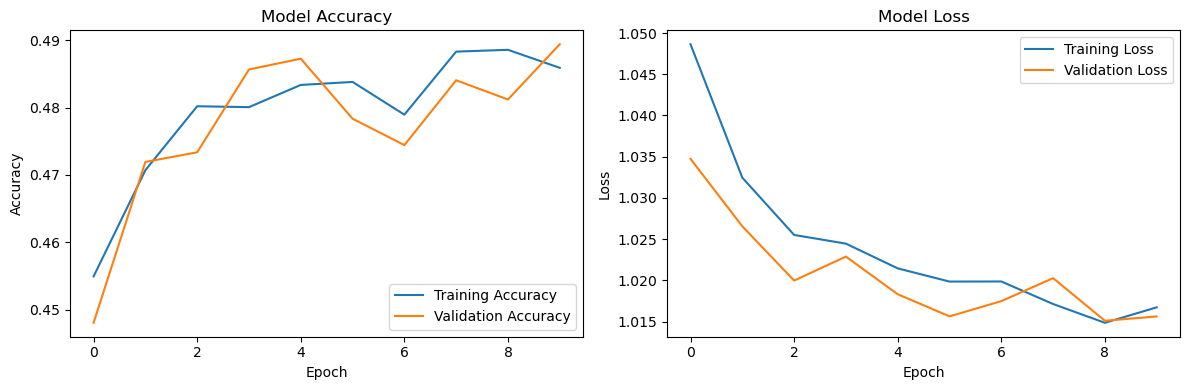

176/176 [==============================] - 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

        High       0.42      0.11      0.18      1219
         Low       0.51      0.31      0.39      1962
      Medium       0.49      0.82      0.61      2430

    accuracy                           0.49      5611
   macro avg       0.47      0.42      0.39      5611
weighted avg       0.48      0.49      0.44      5611



In [60]:
# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
from sklearn.metrics import classification_report
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

#### Confusion matrix

176/176 [==============================] - 0s 1ms/step
Confusion Matrix:
[[ 137  239  843]
 [ 116  610 1236]
 [  77  354 1999]]

Confusion Matrix Breakdown:
Rows represent actual classes
Columns represent predicted classes

Detailed Confusion Matrix:
Actual High: [137 239 843]
Actual Low: [ 116  610 1236]
Actual Medium: [  77  354 1999]


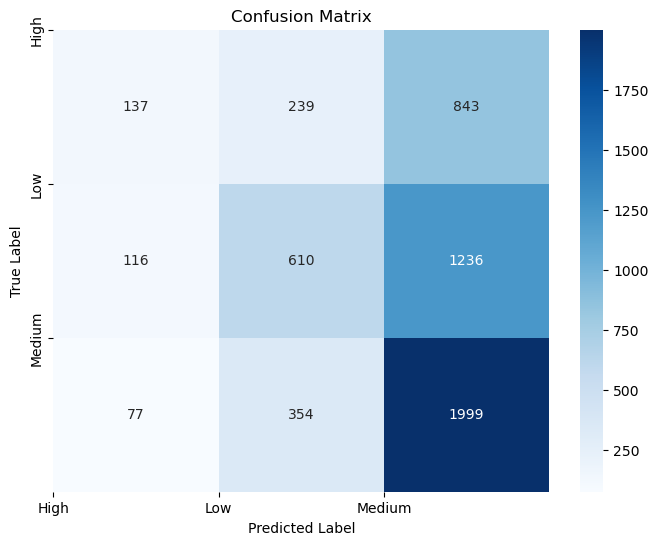

In [62]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print("Rows represent actual classes")
print("Columns represent predicted classes")

# If you want to see with class labels
print("\nDetailed Confusion Matrix:")
for i, actual_class in enumerate(label_encoder.classes_):
    row = cm[i]
    print(f"Actual {actual_class}: {row}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(np.arange(3), label_encoder.classes_)
plt.yticks(np.arange(3), label_encoder.classes_)
plt.show()

### No embeding for prediction

Epoch 1/10
702/702 [==============================] - 3s 3ms/step - loss: 1.0318 - accuracy: 0.4647 - val_loss: 1.0226 - val_accuracy: 0.4734
Epoch 2/10
702/702 [==============================] - 1s 2ms/step - loss: 1.0195 - accuracy: 0.4791 - val_loss: 1.0203 - val_accuracy: 0.4703
Epoch 3/10
702/702 [==============================] - 1s 2ms/step - loss: 1.0154 - accuracy: 0.4814 - val_loss: 1.0185 - val_accuracy: 0.4730
Epoch 4/10
702/702 [==============================] - 1s 2ms/step - loss: 1.0134 - accuracy: 0.4829 - val_loss: 1.0192 - val_accuracy: 0.4723
Epoch 5/10
702/702 [==============================] - 1s 2ms/step - loss: 1.0124 - accuracy: 0.4867 - val_loss: 1.0168 - val_accuracy: 0.4776
Epoch 6/10
702/702 [==============================] - 1s 2ms/step - loss: 1.0114 - accuracy: 0.4873 - val_loss: 1.0165 - val_accuracy: 0.4773
Epoch 7/10
702/702 [==============================] - 1s 2ms/step - loss: 1.0102 - accuracy: 0.4895 - val_loss: 1.0179 - val_accuracy: 0.4764
Epoch 

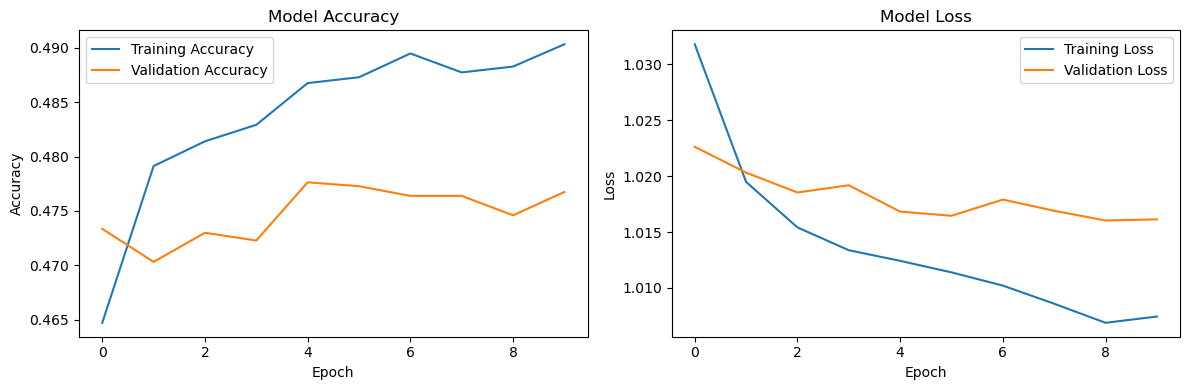

176/176 [==============================] - 0s 940us/step

Classification Report:
              precision    recall  f1-score   support

        High       0.40      0.21      0.27      1219
         Low       0.47      0.26      0.33      1962
      Medium       0.49      0.79      0.60      2430

    accuracy                           0.48      5611
   macro avg       0.46      0.42      0.40      5611
weighted avg       0.46      0.48      0.44      5611



In [63]:
# Combine features without BERT embeddings
X_combined = np.hstack([
    court_encoded,              # One-hot encoded courts
    industry_encoded,           # One-hot encoded industries
    number_patent_scaled        # Scaled number of patents
])

# Prepare the target variable (duration_type)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_records['duration_type'])  # Convert 'low', 'medium', 'high' to 0, 1, 2

# Split data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Build the fusion model
fusion_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_combined.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: low, medium, high
])

fusion_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = fusion_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

# Evaluate the model
loss, accuracy = fusion_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
from sklearn.metrics import classification_report
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

#### Confusion matrix values

176/176 [==============================] - 0s 940us/step
Confusion Matrix:
[[ 251  206  762]
 [ 217  501 1244]
 [ 153  354 1923]]

Confusion Matrix Breakdown:
Rows represent actual classes
Columns represent predicted classes

Detailed Confusion Matrix:
Actual High: [251 206 762]
Actual Low: [ 217  501 1244]
Actual Medium: [ 153  354 1923]


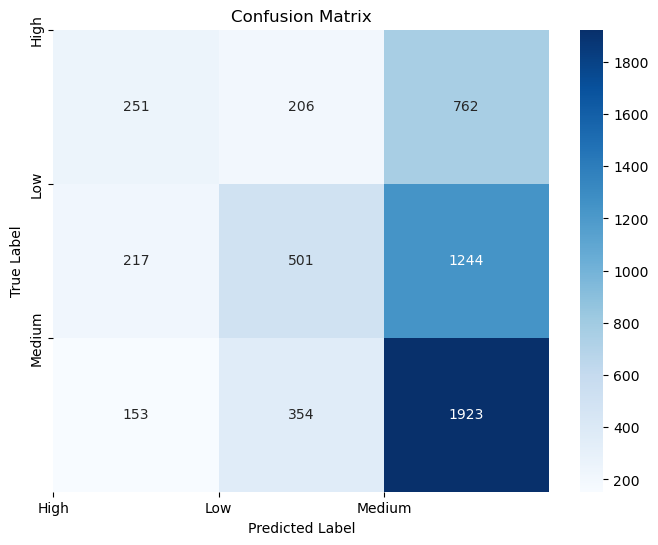

In [64]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes
y_pred = fusion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print("Rows represent actual classes")
print("Columns represent predicted classes")

# If you want to see with class labels
print("\nDetailed Confusion Matrix:")
for i, actual_class in enumerate(label_encoder.classes_):
    row = cm[i]
    print(f"Actual {actual_class}: {row}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(np.arange(3), label_encoder.classes_)
plt.yticks(np.arange(3), label_encoder.classes_)
plt.show()